# 18.3 텍스트 분류

In [1]:
using Pkg
Pkg.activate("/home/bread/JULIA/chap4")
Pkg.instantiate()

  Activating project at `~/JULIA/chap4`


* 바로 앞 절의 문자열 생성 실습에서는 문자 기반 순환 신경망을 사용했다. 이번 절에서는 단어 기반 순환 신경망을 사용하여 텍스트 분류 작업을 시도해본다. 

* 문자와 다르게 단어는 고유한 값이 굉장히 많으므로 원핫 벡터와 같은 희소 표현으로 나타내면 벡터의 차원이 너무 커지게 된다. 이를 해결하기 위해 단어를 밀집 벡터로 바꿔주는 임베딩 계층을 이용할 수 있다. 

* 먼저 사전 학습되지 않은 임베딩 계층으로 분류 작업을 시도해 보고, 사전 훈련된 임베딩 가중치로도 같은 작업을 시도해서 둘의 결과를 비교해볼 것이다. 대상 데이터는 14.2절에서 다뤘던 IMDB 영화평 데이터 셋이다. 

* 토큰화와 정수 인코딩 후 임베딩층을 통과한 영화평 데이터는 두 층의 양방향 LSTM과 어텐션(attention), 밀집 계층을 거쳐서 최종적으로 긍정/부정에 대한 로짓을 출력한다. 

먼저 필요한 패키지들을 로딩한다. 

In [2]:
using CSV, DataFrames
import MLUtils 
import Flux, Optimisers, Zygote, Functors
using Formatting: printfmtln
using TextAnalysis
using Random: MersenneTwister
ENV["DATADEPS_ALWAYS_ACCEPT"] = true # 필요 데이터 자동 다운로드

true

## 데이터셋 준비

1. 임베딩 계층은 단어의 정수 인덱스를 입력으로 받아서 해당 열 위치의 임베딩 벡터를 돌려준다. 

2. 임베딩 계층에 입력으로 넣기 위해서는 단어를 정수 인텍스로 표현한 데이터셋을 만들어야 한다. 

3. 먼저 IMDB 데이터 파일을 읽어서 토큰화한 후, 14.2절에서 다룬 텍스트 전처리 작업을 시행하는 함수를 작성한다.

In [3]:
# 코퍼스 전처리 함수

function prepare_corpus()
    imdb = CSV.read("IMDB Dataset.csv", DataFrame)
    X = replace.(imdb.review, "" => " ")
    X = X.|> tokenize

    X_crps = Corpus(TokenDocument.(X))
    prepare!(X_crps, strip_corrupt_utf8)
    prepare!(X_crps, strip_case)
    prepare!(X_crps, stem_words)
    prepare!(X_crps, strip_non_letters)
    prepare!(X_crps, strip_articles)
    prepare!(X_crps, strip_prepositions)
    prepare!(X_crps, strip_pronouns)
    prepare!(X_crps, strip_stopwords)

    imdb, X_crps
end

prepare_corpus (generic function with 1 method)

다음 함수는 전체 문서에서 발생 빈도가 높은 n개의 단어에 순번을 부여하고, 각 문서의 단어를 이 순번값으로 바꾼 데이터셋을 반환하는 함수이다.

In [4]:
function get_data(num_words, seq_len, batch_size)
    imdb, X_crps = prepare_corpus()
    
    update_lexicon!(X_crps)
    lexi = lexicon(X_crps)
    sorted = map(x -> x[1], sort(collect(lexi), by = x->x[2], rev=true))
    top_words = first(filter(x -> x != "", sorted), num_words)
    word_idx = Dict(x => i + 1 for (i, x) in enumerate(top_words))     
    
    X = map(X_crps) do crp
        idx = map(x -> get(word_idx, x, 0), crp.tokens)
        idx = filter(x -> x != 0, idx)
        if length(idx) > seq_len
            idx[1:seq_len]
        else
            vcat(idx, fill(1, seq_len - length(idx)))
        end
    end
    X = MLUtils.batch(X)
    
    y = ifelse.(imdb.sentiment .== "positive", 1, 0);
    y = Flux.onehotbatch(y, 0:1)

    train, test = MLUtils.splitobs((X, y), at = 0.7);
    train_loader = MLUtils.DataLoader(train, batchsize=batch_size)
    test_loader = MLUtils.DataLoader(test, batchsize=batch_size)
    
    train_loader, test_loader, top_words
end

get_data (generic function with 1 method)

함수 내 update_lexicon! 함수는 코퍼스의 단어 발생 빈도 정보를 업데이트하는 함수이다.

발생 빈도가 높은 순으로 상위 num_words 개의 단어들을 추출한 top_words에 대해 2부터 순번ㅇ르 인덱스로 부여한다. 

1은 문서의 단어 수가 주어진 seq_len보다 짧을 때 채워주는 패딩 인덱스로 사용한다. 

입력 변수 X는 각 문서의 단어들에 대해 top_words에 속한 단어들만 필터하여 인덱스로 바꿔주고, 

seq_len 길이에 맞도록 자르거나 패딩을 해준다. 

종속변수 y는 영화평이 긍정이면 1, 부정이면 0을 부여하는 원핫 인코딩을 한다.
(범주 개수가 둘 밖에 되지 않으므로 원핫 인코딩을 하지 않아도 되지만 앞에서 작성한 train, test, run_batch 함수를 그대로 사용하기 위해 원핫 인코딩을 함)

## 학습 및 테스트 함수

train 함수와 test 함수는 16장에서 작성한 함수를 그대로 사용한다.

In [5]:
function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += batch_size
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", 
        acc, avg_loss)
    acc, avg_loss
end

test (generic function with 1 method)

## 임베딩층

플럭스에서 제공하는 임베딩층의 실제 소스 코드를 통해 임베딩층의 작동 방식을 살펴보자.

- https://github.com/FluxML/Flux.jl/blob/master/src/layers/basic.jl

임베딩층은 가중치 행렬 weight 필드만 가지고 있고, Embedding(1000 => 10)과 같이 생성할 경우, (10 x 1000) 크기의 가중치 행렬을 초기화한다. 

이때, 1000은 보통 전체 어휘 개수가 되고 10은 단어가 매핑되는 임베딩 벡터의 차원이 된다. 임베딩층을 정수 x로 호출하면 weight 필드의 x번째 열을 임베딩 벡터로 반환한다. 이때 넘기는 정수 x는 해당 단어의 전체 어휘에서의 인덱스이다. 임베딩 층을 단어 인덱스의 배열로 호출하면, NNlib.gather 함수를 이용하여 각 단어 인덱스에 해당하는 임베딩 벡터들을 행렬로 반환한다.

In [6]:
struct Embedding{W<:AbstractMatrix}
    weight::W
end

using Functors

@functor Embedding

Embedding((in, out)::Pair{<:Integer, <:Integer}; init = randn32) = Embedding(init(out, in))

(m::Embedding)(x::Integer) = m.weight[:, x]
(m::Embedding)(x::AbstractVector) = NNlib.gather(m.weight, x)

## 어텐션층

임베딩층과 LSTM 층을 거친 단어 시퀀스는 어텐션 층으로 넘겨진다. 어텐션 층은 전체 입력 문장에서 어떤 단어에 더 집중해야 할지를 알려준다. 

플럭스는 닷-프로덕트 어텐션(dot-product attention)은 내장하고 있으나 바다나우(Bahdanau) 어텐션은 내장하지 않아,

여기선 직접 바다나우 어텐션을 구현해본다.

In [7]:
struct Attention
    W1
    W2
    v
end

Attention(h_size; rng) = Attention(
    Flux.Dense(h_size => h_size; init=init(rng)),
    Flux.Dense(h_size => h_size; init=init(rng)),
    Flux.Dense(h_size => 1; init=init(rng))
)

Functors.@functor Attention

function (a::Attention)(hs, q) # hs :(feat, batch, seq), q: (feat, batch)
    attn_sc = dropdims(a.v(tanh.(a.W1(hs) .+ a.W2(q))), dims=1) # (batch, seq)    
    attn_w = Flux.softmax(attn_sc, dims=2)  # (batch, seq)
    hcat([hs[:,i,:]*attn_w[i,:] for i in 1:size(hs,2)]...) # (feat, batch)
end
     

어텐션층의 생성자는 인코더(LSTM) 은닉 상태 벡터의 차원을 입력으로 받아서 가중치 W1, W2, v를 생성한다. 어텐션층 호출 시에는 인코더의 시점별 은닉 상태인 hs 및 어텐션값을 구하려는 대상(쿼리)인 q를 입력으로 받는다. hs는 형상이 (특성(은닉 상태) 차원수 x 배치 크기 x 시퀀스 길이)이고, q는 (특성 차원 수 x 배치 크기)의 형상이다. 

## 모델 정의

- 앞서 살펴본 임베딩층과 어텐션 층을 이용하여 최종적인 모델을 정의한다.

In [8]:
struct MyRNN
    embed       # 단어 임베딩
    rnn_f1      # 첫번째 BiLSTM의 순방향
    rnn_b1      # 첫번째 BiLSTM의 역방향
    rnn_f2      # 두번째 BiLSTM의 순방향
    rnn_b2      # 두번째 BiLSTM의 역방향
    attn        # 바다나우 어텐션
    dense1      # 밀집층 1
    dropout     # 드랍아웃
    dense2      # 밀집층 2
end
Functors.@functor MyRNN

MyRNN 모델은 임베딩층 필드인 embed와 두 층의 양방향 LSTM을 위한 네 개의 rnn 필드를 가진다.

그리고 어텐션 필드인 attn과 두 개의 밀집층 필드, 하나의 드롭아웃 필드를 가진다. 모델의 객체 호출 메서드는 다음과 같다. 

In [9]:
function (a::MyRNN)(X)               # (seq, bat)
    X = a.embed(X)                   # (emb, seq, bat)
    X = permutedims(X, (1,3,2))      # (emb, bat, seq)

    Flux.reset!(a.rnn_f1)
    Flux.reset!(a.rnn_b1)
    Flux.reset!(a.rnn_f2)
    Flux.reset!(a.rnn_b2)
    # 1st BiLSTM
    f = a.rnn_f1(X)                  # (hs, bat, seq)
    f = a.dropout(f)
    b = a.rnn_b1(reverse(X, dims=3)) # (hs, bat, seq)
    b = a.dropout(b)
    X = vcat(f, b)                   # (hs*2, bat, seq)
    # 2nd BiLSTM
    f = a.rnn_f2(X)                  # (hs, bat, seq)
    f = a.dropout(f)
    b = a.rnn_b2(reverse(X, dims=3)) # (hs, bat, seq)
    b = a.dropout(b)
    X = vcat(f, b)                   # (hs*2, bat, seq)
    # attention
    X = a.attn(X, X[:,:,end])        # (hs*2, bat)    
    X = a.dense1(X)
    a.dense2(a.dropout(X))
end

단어 시쿼스들의 배치인 입력 데이터 X는 (시퀀스 길이 x 배치 크기)의 형상이다. 임베딩층을 거친 x는 양방향 LSTM을 두 번 거친다. 양방향 LSTM은 두 LSTM을 각각 시퀀스 순과 시퀀스 역순으로 적용하여 얻은 결과를 연결하면 된다. 두 번의 양방향 LSTM에서 나온 시점별 은닉 상태 및 마지막 은닉 상태를 어텐션 층에 넘겨서 어텐션값을 구하고 다시 두 개의 밀집층을 거쳐서 분류 예측을 한다. 

이렇게 정의된 모델을 생성하는 함수는 다음과 같다.

In [10]:
init(rng) = Flux.glorot_uniform(rng)

function build_model(emb; rng, hs = 64)
    embedding = Flux.Embedding(emb)
    embed_size = size(embedding.weight, 1)
    MyRNN(
        embedding,
        Flux.LSTM(embed_size => hs; init=init(rng)), 
        Flux.LSTM(embed_size => hs; init=init(rng)), 
        Flux.LSTM(hs * 2 => hs; init=init(rng)), 
        Flux.LSTM(hs * 2 => hs; init=init(rng)), 
        Attention(hs * 2; rng=rng),
        Flux.Dense(hs * 2 => hs, Flux.relu; init=init(rng)),
        Flux.Dropout(0.5), 
        Flux.Dense(hs => 2; init=init(rng)))
end

build_model (generic function with 1 method)

이 함수의 emb 인수는 임베도 넘길 인수로, 임베딩층의 차원을 지정할 수도 있고, 사전 학습된 임베딩 가중치를 넘길 수도 있다. hs 인수는 LSTM 층이나 밀집층 등에 적용될 은닉 유닛의 크기를 일괄로 관리하기 위한 파라미터이다. 

## 사전 학습된 임베딩

사전 학습된 단어 임베딩은 Embeddings.jl 패키지를 이용하여 다운로드 할 수 있다. 이 패키지를 이용하면 Word2Vec, Glove, FastText 등의 임베딩을 이용할 수 있다. 여기서는 GloVe 임베딩을 이용한다.

In [11]:
function run_batch(loaders, models, epochs)
    train_loader, test_loader = loaders
    loss_fn(m, X, y) = Flux.Losses.logitcrossentropy(m(X), y)
    train_losses, accuracies = [], []
    for (k, model) in enumerate(models)
        train_loss, accuracy = [], []
        optimizer = Optimisers.setup(Optimisers.Adam(), model)
        for t in 1:epochs
            println("[Model $k] Epochs $t")
            println("-------------------------------")
            model, optimizer, loss = 
                train(train_loader, model, loss_fn, optimizer)
            train_loss = vcat(train_loss, loss)
            acc, _ = test(test_loader, model, loss_fn)
            push!(accuracy, acc)
        end
        push!(train_losses, train_loss)
        push!(accuracies, accuracy)
    end
    train_losses, accuracies
end

run_batch (generic function with 1 method)

In [12]:
import Embeddings
function get_glove_embeddings(words)
    emb = Embeddings.load_embeddings(Embeddings.GloVe{:en});
    vocab_dic = Dict(v => i for (i, v) in enumerate(emb.vocab));
    emb_vecs = [haskey(vocab_dic, x) ? 
        emb.embeddings[:, get(vocab_dic, x, 0)] : 
        randn(Float32, 50) for x in words]
    hcat(zeros(Float32, 50), emb_vecs...)    
end

get_glove_embeddings (generic function with 1 method)

단어 리스트를 words 인수로 받아서, GloVe 임베딩에서 해당 단어의 임베딩 벡터를 뽑아서 새로운 임베딩 가중치 행렬을 만드는 함수이다. GloVe의 임베딩 벡터 차원은 50이다. 가중치 행렬의 첫 번째 열은 words 리스트에 속하지 않는 단어들을 위한 영벡터이다. 

## 최종 결과

지금가지 작업한 함수들을 이용하여 사전 학습되지 않은 model_base 및 사전 학습된 임베딩을 사용하는 model_glove 모델을 만든 후 두 모델의 정확도를 비교해본다. 복수의 모델을 훈련하기 위한 run_batch 함수는 17.1절에서 정의한 run_batch 함수를 그대로 사용한다.

In [13]:
@time begin
    num_words = 10000;
    seq_len = 300;
    batch_size = 64;
    embed_size = 50;

    train_loader, test_loader, top_words = get_data(num_words, seq_len, batch_size);

    rng = MersenneTwister(1)
    model_base = build_model(num_words + 1 => embed_size; rng = rng)
    model_glove = build_model(get_glove_embeddings(top_words); rng = rng)
    models = [model_base, model_glove] .|> Flux.gpu

    losses, accus = run_batch((train_loader, test_loader), models, 5)
end     

[Model 1] Epochs 1
-------------------------------
[Train] loss: 0.6927579 [100/547]
[Train] loss: 0.6893714 [200/547]
[Train] loss: 0.6931084 [300/547]
[Train] loss: 0.6922708 [400/547]
[Train] loss: 0.6939425 [500/547]
[Test] Accuracy: 49.9, Avg loss: 0.6931477
[Model 1] Epochs 2
-------------------------------
[Train] loss: 0.6929804 [100/547]
[Train] loss: 0.6919811 [200/547]
[Train] loss: 0.6932024 [300/547]
[Train] loss: 0.6924396 [400/547]
[Train] loss: 0.6939262 [500/547]
[Test] Accuracy: 49.9, Avg loss: 0.6931477
[Model 1] Epochs 3
-------------------------------
[Train] loss: 0.6931581 [100/547]
[Train] loss: 0.6918925 [200/547]
[Train] loss: 0.6932240 [300/547]
[Train] loss: 0.6924800 [400/547]
[Train] loss: 0.6938892 [500/547]
[Test] Accuracy: 49.9, Avg loss: 0.6931476
[Model 1] Epochs 4
-------------------------------
[Train] loss: 0.6931586 [100/547]
[Train] loss: 0.6918824 [200/547]
[Train] loss: 0.6932244 [300/547]
[Train] loss: 0.6924802 [400/547]
[Train] loss: 0.69388

(Any[Any[0.6927579f0, 0.68937135f0, 0.6931084f0, 0.69227076f0, 0.6939425f0, 0.6929804f0, 0.6919811f0, 0.6932024f0, 0.6924396f0, 0.6939263f0  …  0.6931586f0, 0.69188243f0, 0.69322443f0, 0.69248027f0, 0.6938882f0, 0.6931587f0, 0.6918808f0, 0.69322443f0, 0.69248027f0, 0.6938878f0], Any[0.69316936f0, 0.69172513f0, 0.6932293f0, 0.69246227f0, 0.6939024f0, 0.6931586f0, 0.691875f0, 0.69322443f0, 0.6924725f0, 0.6938939f0  …  0.69315875f0, 0.6918784f0, 0.69322455f0, 0.6924784f0, 0.6938889f0, 0.69315875f0, 0.6918788f0, 0.69322455f0, 0.69247913f0, 0.69388825f0]], Any[Any[49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875], Any[49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875]])

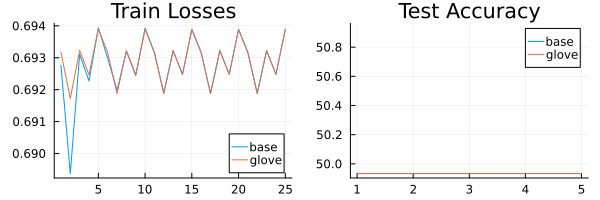

In [14]:

import Plots
Plots.gr(size=(600,200))
label = ["base" "glove"]
title = "Train Losses"
p1 = Plots.plot(losses, label=label, title=title);
title = "Test Accuracy"
p2 = Plots.plot(accus, label=label, title=title);
Plots.plot(p1, p2)
     

발생 빈도가 높은 순으로 10,000개의 단어들을 분석 대상 어휘로 잡았고, 토큰화된 문장의 길이는 300, 임베딩 벡터의 차원은 50으로 했다. 이 실행 결과에 대해 학습셋의 배치별 손실 및 테스트셋의 에폭별 정확도를 위와 같이 시각화한다. 

- 사전 학습된 GloVe 임베딩을 사용한 model_glove가 베이스 모델보다 학습 손실이 더 빠르게 줄어들고, 정확도도 3에폭 만에 87%가 넘었음을 볼 수 있다.